# Find MSLP analogues of ERA5 event 

- selects desired precipitation event
- searches for analogues in ERA5 dataset
- searches for analogues in CRCM5 Large Ensemble

### Packages and Directories

In [1]:
# --- Imports ---
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client, LocalCluster
from scipy.interpolate import griddata
import calendar
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Custom Functions ---
# sys.path.append('/home/portal/script/python/precip_Cristina/')                    # tintin
sys.path.append('/home/alice/Desktop/work/git/myISACcode/python/precip_Cristina')   # alice
import functions_analogues_PrMax as fanPM
import functions_analogues_LUCAFAMOSS as fan

In [2]:
# Define directories for data and figures
# # tintin
# CERRA_dir = '/work_big/users/clima/portal/CERRA-Land/'
# ERA5_dir = '/work_big/users/clima/portal/ERA5/'
# CRCM5_dir = '/work_big/users/clima/portal/CRCM5-LE/'
# fig_dir = '/home/portal/figures/case-studies_byNode/'

# alice
CERRA_dir = '/media/alice/Crucial X9/portal/data_CNR/CERRA/'
ERA5_dir = '/media/alice/Crucial X9/portal/data_CNR/ERA5/'
CRCM5_dir = '/media/alice/Crucial X9/portal/data_CNR/CRCM5-LE/'
fig_dir = '/home/alice/Desktop/CNR/ENCIRCLE/materiale_alice/figures/analogues/'
pslmin_dir = './analogue_data/psl_min/'

### Identifies event in time and space

In [17]:
# Event selection
lselect = 'alert-regions'  # 'Italy' or 'wide-region' or 'alert-regions'
no_node = 3
no_event = 3
# Upload the data
if lselect == 'wide-region':
    df_events = pd.read_excel(CERRA_dir+'events_on_wide_regions.xlsx', sheet_name=no_node-1)
elif lselect == 'alert-regions':
    df_events = pd.read_excel(CERRA_dir+'events_cum_on_above99_alertregions_CERRA.xlsx', sheet_name=no_node-1)
elif lselect == 'Italy':
    df_events = pd.read_excel(CERRA_dir+'events_on_Italy.xlsx', sheet_name=no_node-1)
time_event = df_events['Time'].iloc[no_event-1] + pd.Timedelta('12h')
doy_event =  time_event.timetuple().tm_yday
# Define lon-lat box of event
box_event = fanPM.box_event_PrMax_alertregions(no_node,no_event)

# Event information
print('Event time:', time_event)
print('Event DOY:', doy_event)
print('Event box:', box_event)

Event time: 2016-11-24 18:00:00
Event DOY: 329
Event box: [0, 15, 35, 48]


In [18]:
# Defines the months for analogue selection
month_event = time_event.month
months_sel = [month_event-1, month_event, month_event+1]
# Get the month names
month_names = [calendar.month_abbr[month] for month in months_sel]
# Extract the initials
str_months = ''.join([name[0] for name in month_names])

# Months for analogue selection
print('Season (selection of 3 months) for analogue search:', str_months)

Season (selection of 3 months) for analogue search: OND


### Upload event data in ERA5 (anom & clim)

In [19]:
# Upload event mslp data
dmslp_event = fanPM.load_ERA5_data('mslp', 'daily', time_event, box_event, l_anom=True, data_dir=ERA5_dir+'mslp/')
mslp_clim = fanPM.load_ERA5_clim('mslp', doy_event, box_event, l_smoothing=True, data_dir=ERA5_dir+'mslp/climatology/')

#### Plot event field

/tmp/ipykernel_20159/3436260555.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


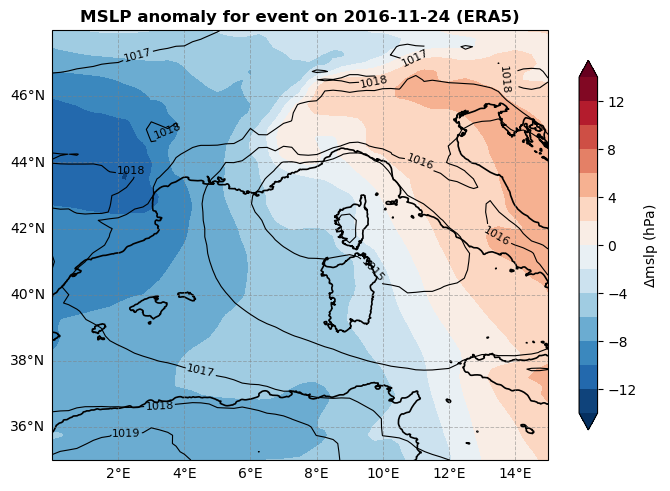

In [20]:
# Plot event
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(8, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}
    )
fanPM.plot_anom_event(ax, "mslp", dmslp_event.longitude, dmslp_event.latitude, dmslp_event.values, mslp_clim, 
                      "MSLP anomaly for event on "+str(time_event)[:10]+" (ERA5)")
fig.show()
fig.savefig(fig_dir+'mslp_node'+str(no_node)+'_extreme'+str(no_event)+'-alertregions_box-analogues.png')

#### Select ERA5 event data to event box at 0.5 resolution

In [21]:
dmslp_event_regridded = fanPM.regrid_with_xesmf(dmslp_event, box_event, resolution=0.5)
mslp_clim_regridded = fanPM.regrid_with_xesmf(mslp_clim, box_event, resolution=0.5)

/home/alice/anaconda3/envs/xesmf_env/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/alice/anaconda3/envs/xesmf_env/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


## Find analogues in ERA5

### Parameters of data selection

In [22]:
# Variable
varname = 'mslp'
# Time
year_range = [2004, 2023]
years_sel = np.arange(year_range[0], year_range[1]+1)

### Load and preprocess data for analogue search

In [23]:
# Define the file pattern for loading mslp data
file_pattern = ERA5_dir + varname +"/res05/ERA5_"+varname+"_NH_daily_*_anom_regridded-to-CRCM5.nc"
dmslp_tmp = xr.open_mfdataset(file_pattern, combine='by_coords', parallel=True)['msl'] * 0.01
dmslp_tmp = dmslp_tmp.sel(time=dmslp_tmp.time.dt.month.isin(months_sel))
dmslp_tmp = dmslp_tmp.sel(time=dmslp_tmp.time.dt.year.isin(years_sel))

# Define and select lon lat masks (specific of each event)
lon_mask, lat_mask = fanPM.lonlat_mask(dmslp_tmp.lon.values, dmslp_tmp.lat.values, box_event)
mask = lat_mask[:, np.newaxis] & lon_mask
mask_xr = xr.DataArray(
    mask,
    dims=["lat", "lon"],
    coords={"lat": dmslp_tmp.lat, "lon": dmslp_tmp.lon},
)

# Apply mask to the dataset
dmslp_sel = dmslp_tmp.where(mask_xr, drop=True)

### Quantile selection

In [24]:
# Quantile
qtl = 0.99
# Fix number of analogues based on the quantile
n_analogues = int(np.round(len(dmslp_sel.time) * (1-qtl)))
n_analogues = 18
print('Number of analogues to be selected:', n_analogues)
# Minimum spacing between analogues
analogue_spacing = 7 # days

Number of analogues to be selected: 18


### Compute Euclidean distance from event

In [25]:
# Compute euclidean distance from the event to the selected mslp data
dist = fan.function_distance(dmslp_event_regridded, dmslp_sel, nan_version=True)

### Analogue selection

1. Identify a large pool of analogues using qtl_0sel

2. Exclude analogues within ±7 days of their associated event

3. Select analogues with >=7-day spacing between them (keeping best n_analogues, i.e. 1st percentile of days after analogue filtering)

4. Average selected analogues, if at least n_analogues have been selected

In [26]:
# First search of n_analogues
factor_0sel = 2
qtl_0sel = 1 - ((1 - qtl) * factor_0sel)  # First selection of the quantile, for extracting a total of n_analogues
l_0sel = True  # Flag for selection of analogues

while l_0sel:
    # Compute log-transformed distance
    logdist = np.log(1 / dist)
    # Threshold at given quantile 0sel
    thresh_0sel = np.percentile(logdist, qtl_0sel * 100, axis=0)
    mask_analogues = logdist >= thresh_0sel
    
    # Event time, all times and required time spacing
    all_times = dmslp_sel.time.values
    event_time = dmslp_event.time.values
    
    # Exclude analogue times within ±7 days of their associated event
    time_diff = np.abs((all_times - event_time).astype('timedelta64[D]').astype(int))
    mask_analogues &= np.array(time_diff) >= analogue_spacing  # update mask to exclude times too close to the event
    indices_analogues = np.where(mask_analogues)[0]  # indices of all valid analogue times
    
    # Filter analogues based on the mask and logdist, ensuring they are spaced correctly (analogue_spacing days apart)
    indices_filtered_analogues = fan.timefilter_analogues(indices_analogues, logdist, all_times, analogue_spacing)

    if len(indices_filtered_analogues)>=n_analogues:
        indices_filtered_analogues = indices_filtered_analogues[:n_analogues]  # Select the first n_analogues (corresponding to the quantile qtl)
        l_0sel = False
        print("Selection completed using pool data from quantile", qtl_0sel)
    else:
        factor_0sel +=1
        qtl_0sel = 1 - ((1 - qtl) * factor_0sel)
    
# Save distance and times of selected analogues
listdistances = dist[indices_filtered_analogues]
listtimes = dmslp_sel.time.values[indices_filtered_analogues]

# Select and average
thresh = dist[indices_filtered_analogues[-1]]
dmslp_analogues = dmslp_sel.isel(time=indices_filtered_analogues) 
dmslp_analogues_mean = dmslp_analogues.mean(dim='time')
dmslp_analogues_mean_values = dmslp_analogues_mean.values

Selection completed using pool data from quantile 0.98


/tmp/ipykernel_20159/710151475.py:8: RuntimeWarning: divide by zero encountered in divide
  logdist = np.log(1 / dist)


In [27]:
# Print the selected analogue times
print("Selected "+str(n_analogues)+" analogue times:\n", all_times[indices_filtered_analogues])
print('Threshold distance', thresh)

Selected 18 analogue times:
 [cftime.DatetimeNoLeap(2019, 10, 23, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2018, 10, 31, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2007, 11, 22, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2016, 10, 23, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2008, 11, 2, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2018, 10, 10, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2019, 12, 18, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2010, 10, 9, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2006, 10, 26, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2006, 10, 18, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2005, 11, 15, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2017, 10, 19, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2020, 12, 15, 9, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2011, 10, 27, 9, 0, 0, 0, has_year_zero=True)
 cftime

#### Optional: climatology from ERA5 analogue selection

In [28]:
doy_analogues = dmslp_analogues['time'].dt.dayofyear # day-of-year (DOY) from each analogue date
clim_analogues_sum = None # Initialize sum of climatology fields

# Loop through each DOY and accumulate corresponding climatology
for i, doy in enumerate(doy_analogues):
    # Load climatology for the specific DOY
    clim_day = fanPM.load_ERA5_clim('mslp', doy.item(), box_event, l_smoothing=True, data_dir=ERA5_dir+'mslp/climatology/').squeeze()

    # Accumulate climatology
    if i == 0:
        clim_analogues_sum = clim_day
    else:
        clim_analogues_sum += clim_day

# Compute average climatology over all analogue dates
clim_analogues = clim_analogues_sum / len(doy_analogues)
clim_analogues_regridded = fanPM.regrid_with_xesmf(clim_analogues, box_event, resolution=0.5) # Regrid to the desired resolution


/home/alice/anaconda3/envs/xesmf_env/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


#### Compute mean on ERA5 analogues

/tmp/ipykernel_20159/541798807.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


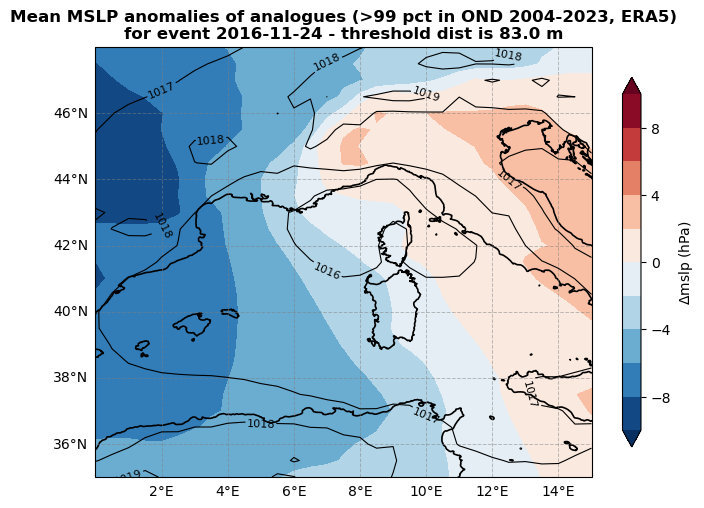

In [29]:
# Plot analogue mean
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(8, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}
    )
fanPM.plot_anom_event(ax, "mslp", dmslp_analogues_mean.lon, dmslp_analogues_mean.lat, dmslp_analogues_mean_values, clim_analogues_regridded,
                      "Mean MSLP anomalies of analogues (>"+str(int(qtl*100))+" pct in "+str_months+' '+str(year_range[0])+'-'+str(year_range[1])+", ERA5)\nfor event "+str(time_event)[:10]+\
                        " - threshold dist is "+str(np.round(thresh))+" m")
fig.show()
fig.savefig(fig_dir+'analogues-mslp_node'+str(no_node)+'_extreme'+str(no_event)+'-alertregions_mean_'+str(int(qtl*100))+'pct_'+str_months+'_'+str(year_range[0])+'-'+str(year_range[1])+'_ERA5.png')

### Compute pmin (abs and from boxmean)

In [30]:
# Compute pmin (abs and from boxmean)
pmin = dmslp_analogues.min(dim=['lon', 'lat'], skipna=True)
pmean = dmslp_analogues.mean(dim=['lon', 'lat'], skipna=True)
pmin_from_boxmean = (dmslp_analogues - pmean).min(dim=['lon', 'lat'], skipna=True)
# Save pmin values
pmin.to_netcdf(f"{pslmin_dir}analogues-{varname}_min-{varname}_node{no_node}-extreme{no_event}-alertregions_{int(qtl*100)}pct_{year_range[0]}-{year_range[1]}_ERA5.nc")
pmin_from_boxmean.to_netcdf(f"{pslmin_dir}analogues-{varname}_min-from-boxmean-{varname}_node{no_node}-extreme{no_event}-alertregions_{int(qtl*100)}pct_{year_range[0]}-{year_range[1]}_ERA5.nc")